In [ ]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import spacy
import re
import numpy as np

# Initialize spaCy model
nlp = spacy.load("en_core_web_sm")

# Sample text data
data = {
    'Text': [
        "I love this product, it works wonderfully!", 
        "This is absolutely the worst experience I’ve ever had.",
        "Maybe this one will be better, I'm not sure.",
        "I can't believe how good it is.",
        "I don't think it's going to work."
    ],
    'Label': [1, 0, 1, 1, 0]  # Example labels (1: Positive, 0: Negative)
}
Corpus = pd.read_csv("compiled_output.csv")
Corpus.head()
df = pd.DataFrame()

# 1. **Extract N-grams (Unigrams, Bigrams, Trigrams)**
def extract_ngrams(text, ngram_range=(1, 3)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    ngrams = vectorizer.fit_transform([text])
    return vectorizer.get_feature_names_out()

# 2. **Argument Lexicons (Agreement and Disagreement)**
agreement_lexicon = ['agree', 'yes', 'definitely', 'sure', 'absolutely', 'of course']
disagreement_lexicon = ['disagree', 'no', 'never', 'not', 'don’t', 'won’t']

def extract_argument_lexicon_features(text):
    agreement_count = sum([word in text.lower() for word in agreement_lexicon])
    disagreement_count = sum([word in text.lower() for word in disagreement_lexicon])
    return agreement_count, disagreement_count

# 3. **Extract Hedge Features**
hedge_words = ['perhaps', 'maybe', 'possibly', 'could', 'might', 'probably']

def extract_hedge_features(text):
    hedge_count = sum([word in text.lower() for word in hedge_words])
    return hedge_count

# 4. **Extract Modal Verbs (Using spaCy)**
def extract_modal_verbs(text):
    doc = nlp(text)
    modal_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would']
    modal_count = sum([token.lemma_ in modal_verbs for token in doc])
    return modal_count

# 5. **Negation Detection (Using Regular Expressions)**
def detect_negation(text):
    negation_patterns = [r'\b(not|no|never|don\'t|won\'t|isn\'t|aren\'t|can\'t)\b']
    negation_count = sum([bool(re.search(pattern, text.lower())) for pattern in negation_patterns])
    return negation_count

# Step 3: Preprocess the Text and Extract Features

def extract_features(df):
    all_ngrams = []
    other_features = []
    
    for text in df['Text']:
        # Extract n-grams (Unigrams, Bigrams, Trigrams)
        ngrams = extract_ngrams(text)
        ngram_features = list(ngrams)  # Get the ngram features
        
        # Extract argument lexicons (agreement, disagreement)
        agreement_count, disagreement_count = extract_argument_lexicon_features(text)

        # Extract hedge features
        hedge_count = extract_hedge_features(text)

        # Extract modal verbs
        modal_count = extract_modal_verbs(text)

        # Extract negation features
        negation_count = detect_negation(text)

        # Combine all the features into one list
        other_features.append([agreement_count, disagreement_count, hedge_count, modal_count, negation_count])

        # Store the ngram features as a separate part of the feature matrix
        all_ngrams.append(ngram_features)
    
    return all_ngrams, other_features

# Step 4: Feature Extraction and Model Training

# Extract n-grams and other features
ngrams, other_features = extract_features(df)

# Create a CountVectorizer to extract features for all n-grams (unigrams, bigrams, trigrams)
vectorizer = CountVectorizer(ngram_range=(1, 3))  # Extract unigrams, bigrams, and trigrams
X_ngrams = vectorizer.fit_transform(df['Text'])

# Now, we need to combine the n-gram features and other features
import numpy as np

# Convert the n-grams matrix to a dense array and concatenate with other features
X_ngrams_dense = X_ngrams.toarray()
X_combined = np.hstack([X_ngrams_dense, np.array(other_features)])

# Convert labels to a numpy array
y = df['Label'].values

# Check class distribution before the split
print("Class distribution in the dataset:")
print(df['Label'].value_counts())

# Stratified split ensures that the distribution of classes is maintained in both the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42, stratify=y)

# Convert numpy arrays to pandas Series to use value_counts
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Check class distribution after the split
print("Class distribution in the training set:")
print(y_train_series.value_counts())

print("Class distribution in the test set:")
print(y_test_series.value_counts())

# 5. **Train Logistic Regression Model**
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')  # Optional: Use class weights if data is imbalanced
log_reg.fit(X_train, y_train)

# 6. **Make Predictions and Evaluate**
y_pred = log_reg.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [3]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
Corpus = pd.read_csv("compiled_output.csv")
Corpus.head()

,Text,Label
0,complicated 3D character models are widely use...,background_claim
1,The range of breathtaking realistic 3D models ...,background_claim
2,a production cannot afford major revisions,background_claim
3,providing a flexible and efficient solution to...,own_claim
4,Skeleton Subspace Deformation (SSD) is the pre...,background_claim


In [5]:
len(Corpus)

13592

In [6]:
Corpus.shape

(13592, 2)

In [7]:
Corpus.isnull().any()

Text     False
Label    False
dtype: bool

In [8]:
Corpus.sample(5)

,Text,Label
13300,One solution is to use Baumgarte stabilization,own_claim
8086,The problem left here,background_claim
2669,In practice this has been considered the major...,background_claim
11944,a multitude of different cloth models have eme...,background_claim
10729,16,data


In [9]:
Corpus.columns

Index(['Text', 'Label'], dtype='object')

Text(0.5, 1.0, 'countplot')

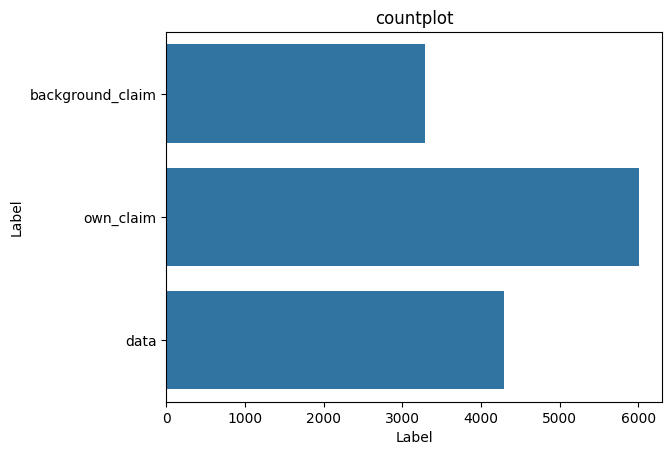

In [10]:
sns.countplot(Corpus.Label)
plt.xlabel("Label")
plt.title("countplot")

In [23]:
import nltk
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_per

True

In [24]:
import nltk
from nltk.tokenize import word_tokenize

# Assuming Corpus is a pandas DataFrame
Corpus['Text'] = [entry.lower() for entry in Corpus['Text']]

# Tokenization
Corpus['Text'] = [word_tokenize(entry) for entry in Corpus['Text']]

# Display the first few tokenized entries
print(Corpus['Text'].head())


0    [complicated, 3d, character, models, are, wide...
1    [the, range, of, breathtaking, realistic, 3d, ...
2    [a, production, can, not, afford, major, revis...
3    [providing, a, flexible, and, efficient, solut...
4    [skeleton, subspace, deformation, (, ssd, ), i...
Name: Text, dtype: object


In [29]:

# 1. Removing Blank Spaces
Corpus['Text'].dropna(inplace=True)
# 2. Changing all text to lowercase
Corpus['text_original'] = Corpus['Text']
Corpus['Text'] = [
    [word.lower() for word in entry] if isinstance(entry, list) else entry.lower()
    for entry in Corpus['Text']
]
#Corpus['Text'] = [entry.lower() for entry in Corpus['Text']]
# 3. Tokenization-In this each entry in the corpus will be broken into set of words
Corpus['Text'] = [
    [word.lower() for word in entry] if isinstance(entry, list) else entry.lower()  # Lowercase each word in list
    for entry in Corpus['Text']
]
#Corpus['Text']= [word_tokenize(entry) for entry in Corpus['Text']]
# 4. Remove Stop words, Non-Numeric and perfoming Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

Corpus.head()

,Text,Label,text_original,text
0,"[complicated, 3d, character, models, are, wide...",background_claim,"[complicated, 3d, character, models, are, wide...",complicated 3d character models are widely use...
1,"[the, range, of, breathtaking, realistic, 3d, ...",background_claim,"[the, range, of, breathtaking, realistic, 3d, ...",the range of breathtaking realistic 3d models ...
2,"[a, production, can, not, afford, major, revis...",background_claim,"[a, production, can, not, afford, major, revis...",a production cannot afford major revisions
3,"[providing, a, flexible, and, efficient, solut...",own_claim,"[providing, a, flexible, and, efficient, solut...",providing a flexible and efficient solution to...
4,"[skeleton, subspace, deformation, (, ssd, ), i...",background_claim,"[skeleton, subspace, deformation, (, ssd, ), i...",skeleton subspace deformation (ssd) is the pre...


In [31]:
for index,entry in enumerate(Corpus['Text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

In [32]:
Corpus.drop(['text'], axis=1)
output_path = 'preprocessed_data.csv'
Corpus.to_csv(output_path, index=False)

In [33]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['Label'],test_size=0.1)

In [35]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [36]:
Tfidf_vect = TfidfVectorizer(max_features=3000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

print(Tfidf_vect.vocabulary_)
#print(len(Tfidf_vect.vocabulary_))

{'complicate': np.int64(493), 'character': np.int64(404), 'model': np.int64(1694), 'widely': np.int64(2945), 'use': np.int64(2842), 'field': np.int64(1004), 'entertainment': np.int64(877), 'virtual': np.int64(2891), 'reality': np.int64(2141), 'range': np.int64(2118), 'realistic': np.int64(2139), 'limit': np.int64(1529), 'artist': np.int64(174), 'resolution': np.int64(2239), 'device': np.int64(715), 'production': np.int64(2046), 'afford': np.int64(76), 'major': np.int64(1589), 'provide': np.int64(2072), 'flexible': np.int64(1031), 'efficient': np.int64(824), 'solution': np.int64(2479), 'animation': np.int64(127), 'remain': np.int64(2205), 'open': np.int64(1826), 'problem': np.int64(2035), 'skeleton': np.int64(2451), 'subspace': np.int64(2584), 'deformation': np.int64(664), 'ssd': np.int64(2524), 'approach': np.int64(147), 'skin': np.int64(2454), 'present': np.int64(2013), 'drive': np.int64(795), 'natural': np.int64(1740), 'believable': np.int64(266), 'manner': np.int64(1600), 'trivial':

In [37]:
print(len(Tfidf_vect.vocabulary_))

3000


In [30]:
print(Train_X_Tfidf)


  (0, 2924)	0.1390753122926916
  (0, 2896)	0.07412735351588047
  (0, 2878)	0.14905733048510242
  (0, 2789)	0.1390753122926916
  (0, 2536)	0.1390753122926916
  (0, 2481)	0.14563567250311146
  (0, 2447)	0.10095556517591824
  (0, 2255)	0.05748708403031139
  (0, 2214)	0.34507328891429856
  (0, 2136)	0.1390753122926916
  (0, 1965)	0.16312619494728364
  (0, 1593)	0.14251519751370173
  (0, 1362)	0.08501067145083095
  (0, 1208)	0.14905733048510242
  (0, 1205)	0.14905733048510242
  (0, 1150)	0.3262523898945673
  (0, 1138)	0.1390753122926916
  (0, 1119)	0.1390753122926916
  (0, 1114)	0.06585494657367123
  (0, 1111)	0.4893785848418509
  (0, 1107)	0.13170989314734247
  (0, 1045)	0.05509316322579257
  (0, 1027)	0.11502442963809952
  (0, 1026)	0.1390753122926916
  (0, 833)	0.14905733048510242
  :	:
  (71, 419)	0.03419354065603623
  (71, 411)	0.04661514917658631
  (71, 408)	0.04661514917658631
  (71, 393)	0.026636639947414092
  (71, 383)	0.03974233832524088
  (71, 335)	0.0825226095197288
  (71, 303)	

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(C=1.0, max_iter=100, solver='lbfgs', random_state=42)

# Fit the model on the training dataset
log_reg.fit(Train_X_Tfidf, Train_Y)

# Predict the labels on the validation (test) dataset
predictions_log_reg = log_reg.predict(Test_X_Tfidf)

# Calculate the accuracy score
print("Logistic Regression Accuracy Score -> ", accuracy_score(predictions_log_reg, Test_Y) * 100)


Logistic Regression Accuracy Score ->  67.5


In [38]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  67.3529411764706


In [39]:
#print(classification_report(Test_Y,predictions_SVM))

In [40]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)


Naive Bayes Accuracy Score ->  58.08823529411765


In [41]:
Corpus.head()

,Text,Label,text_original,text,text_final
0,"[complicated, 3d, character, models, are, wide...",background_claim,"[complicated, 3d, character, models, are, wide...",complicated 3d character models are widely use...,"['complicate', 'character', 'model', 'widely',..."
1,"[the, range, of, breathtaking, realistic, 3d, ...",background_claim,"[the, range, of, breathtaking, realistic, 3d, ...",the range of breathtaking realistic 3d models ...,"['range', 'breathtaking', 'realistic', 'model'..."
2,"[a, production, can, not, afford, major, revis...",background_claim,"[a, production, can, not, afford, major, revis...",a production cannot afford major revisions,"['production', 'afford', 'major', 'revision']"
3,"[providing, a, flexible, and, efficient, solut...",own_claim,"[providing, a, flexible, and, efficient, solut...",providing a flexible and efficient solution to...,"['provide', 'flexible', 'efficient', 'solution..."
4,"[skeleton, subspace, deformation, (, ssd, ), i...",background_claim,"[skeleton, subspace, deformation, (, ssd, ), i...",skeleton subspace deformation (ssd) is the pre...,"['skeleton', 'subspace', 'deformation', 'ssd',..."


In [ ]:
preprocessed_data_MS

In [38]:
data = pd.read_csv("E:/MS_AI_IUB_DATASETS_2022/NLP/preprocessed_data_MS.csv")
data.head()

,reviews,Label,text_original,text,text_final
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,"['one', 'of', 'the', 'other', 'reviewers', 'ha...","['one', 'reviewer', 'mention', 'watch', 'oz', ..."
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. <br /><br />The...,"['a', 'wonderful', 'little', 'production', '.'...","['wonderful', 'little', 'production', 'br', 'b..."
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,"['i', 'thought', 'this', 'was', 'a', 'wonderfu...","['think', 'wonderful', 'way', 'spend', 'time',..."
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,"['basically', 'there', ""'s"", 'a', 'family', 'w...","['basically', 'family', 'little', 'boy', 'jake..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...","['petter', 'mattei', ""'s"", '``', 'love', 'in',...","['petter', 'mattei', 'love', 'time', 'money', ..."


In [39]:
Corpus.drop(['text_final'], axis=1)
output_path = 'preprocessed_Text.csv'
Corpus.to_csv(output_path, index=False)

In [41]:
pre = pd.read_csv("E:/MS_AI_IUB_DATASETS_2022/NLP/preprocessed_Text.csv")
pre.head()

,reviews,Label,text_original,text,text_final
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,"['one', 'of', 'the', 'other', 'reviewers', 'ha...","['one', 'reviewer', 'mention', 'watch', 'oz', ..."
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. <br /><br />The...,"['a', 'wonderful', 'little', 'production', '.'...","['wonderful', 'little', 'production', 'br', 'b..."
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,"['i', 'thought', 'this', 'was', 'a', 'wonderfu...","['think', 'wonderful', 'way', 'spend', 'time',..."
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,"['basically', 'there', ""'s"", 'a', 'family', 'w...","['basically', 'family', 'little', 'boy', 'jake..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...","['petter', 'mattei', ""'s"", '``', 'love', 'in',...","['petter', 'mattei', 'love', 'time', 'money', ..."


In [47]:
da = pre.drop(["reviews", "text_original", "text"], axis = 1)

da.head()

,Label,text_final
0,positive,"['one', 'reviewer', 'mention', 'watch', 'oz', ..."
1,positive,"['wonderful', 'little', 'production', 'br', 'b..."
2,positive,"['think', 'wonderful', 'way', 'spend', 'time',..."
3,negative,"['basically', 'family', 'little', 'boy', 'jake..."
4,positive,"['petter', 'mattei', 'love', 'time', 'money', ..."


In [48]:
output_path = 'Preprocess.csv'
da.to_csv(output_path, index=False)

In [49]:
df = pd.read_csv("E:/MS_AI_IUB_DATASETS_2022/NLP/preprocess.csv")
df.head()

,Label,text_final
0,positive,"['one', 'reviewer', 'mention', 'watch', 'oz', ..."
1,positive,"['wonderful', 'little', 'production', 'br', 'b..."
2,positive,"['think', 'wonderful', 'way', 'spend', 'time',..."
3,negative,"['basically', 'family', 'little', 'boy', 'jake..."
4,positive,"['petter', 'mattei', 'love', 'time', 'money', ..."
